In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
# Загружаем датасет
url = 'https://raw.githubusercontent.com/isnikitin1/SalaryResearch/master/all_vacancies_clean.xlsx'
df = pd.read_excel(url)



---


###**Предобработка и подготовка данных**


---



### 1. Избавление от признаков `id`, `name`, `alternate_url`, `salary_from`, `salary_to`
- Признаки `id`, `name`, `alternate_url` не несут практической ценности при прогнозировании.
- `salary_from`, `salary_to` являются составляющими `salary`, который мы хотим предзсказывать.
- **Цель**: Исключение неинформативных для обучения и предубеждение утечки данных.

### 2. Преобразование `key_skills`
- Пропущенные значения в столбце `key_skills` заполняются пустыми списками (`fillna('')`).
- Строки преобразуются в списки навыков, разделяя по запятым с пробелом (`split(', ')`).
- **Цель**: Подготовка для кодирования навыков.

### 3. Отбор топ-50 навыков
- Частота каждого навыка подсчитывается с помощью `Counter`, выбираются 30 самых популярных (`most_common(50)`).
- Создается столбец `key_skills_top`, содержащий только эти навыки.
- **Цель**: Снижение размерности данных и устранение шума от редких навыков.

### 4. Новый признак: количество навыков
- Создается столбец `skills_count`, рассчитывающий количество навыков в каждом наблюдении через `apply(len)`.
- **Цель**: Отражение сложности вакансии или уровня квалификации.

### 5. Ограничение числа уникальных компаний (топ-100 + Other)
- Выбираются 100 самых частых компаний с помощью `value_counts().head(100)`.
- Остальные заменяются категорией "Other" с помощью `where`.
- **Цель**: Уменьшение размерности, сохранение ключевых работодателей.

### 6. Кодирование
- **MultiLabelBinarizer** применяется для кодирования `key_skills_top` в бинарные столбцы для каждого навыка.
- `get_dummies` используется для one-hot кодирования категориальных признаков: `experience`, `schedule`, `area`, `company`.
- **Цель**: Преобразование категориальных переменных в числовой формат для модели.

### 7. Объединение признаков
- Все закодированные и новые признаки объединяются в единый `DataFrame` `X` с помощью `pd.concat`.
- Целевая переменная `y` преобразуется с помощью `np.log1p` для сглаживания масштаба зарплат.

### 8. Масштабирование признаков
- Применяется `StandardScaler` для нормализации признаков в `X_scaled`.
- **Цель**: Улучшение сходимости градиентных методов и работы линейных моделей.

### 9. Разделение данных
- Данные делятся на обучающую (80%) и тестовую (20%) выборки с помощью `train_test_split`, с фиксированным `random_state=42`.
- **Цель**: Обеспечение воспроизводимости и разделения для оценки модели.

In [ ]:
# Избавляемся от признаков, которые не хотим включать в обучение
df.drop(columns=['id', 'name', 'alternate_url', 'salary_from', 'salary_to'], inplace=True)

# Преобразуем key_skills
df['key_skills'] = df['key_skills'].fillna('').apply(lambda x: x.split(', ') if x else [])

# Отбор топ-50 навыков
skills_counts = Counter([skill for skills in df['key_skills'] for skill in skills if skill])
top_skills = [skill for skill, count in skills_counts.most_common(50)]
df['key_skills_top'] = df['key_skills'].apply(lambda x: [skill for skill in x if skill in top_skills])

# Новый признак: количество навыков
df['skills_count'] = df['key_skills'].apply(len)

# Ограничим число уникальных компаний (топ-100 + Other)
top_companies = df['company'].value_counts().head(100).index
df['company'] = df['company'].where(df['company'].isin(top_companies), 'Other')

# Кодирование
mlb = MultiLabelBinarizer()
key_skills_encoded = pd.DataFrame(mlb.fit_transform(df['key_skills_top']), columns=mlb.classes_, index=df.index)
experience_encoded = pd.get_dummies(df['experience'], prefix='experience')
schedule_encoded = pd.get_dummies(df['schedule'], prefix='schedule')
area_encoded = pd.get_dummies(df['area'], prefix='area')
company_encoded = pd.get_dummies(df['company'], prefix='company')
vacancy_type_encoded = pd.get_dummies(df['Vacancy type'], prefix='vacancy type')

# Объединяем признаки
X = pd.concat([key_skills_encoded, experience_encoded, schedule_encoded, area_encoded, company_encoded, vacancy_type_encoded], axis=1)
y = np.log1p(df['salary'])  # Логарифмическое преобразование

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



---
###Обучение модели

Линейная регрессия


---




In [ ]:
# функция, чтоб был симпатичный вывод метрик
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def print_metrics(y_true_train, y_pred_train, y_true_test, y_pred_test, model_name):
    print(f"{model_name}:")
    print(f"{'Metric':<10}{'Train':<15}{'Test':<15}")
    print("—" * 35)

    # R² — коэффициент детерминации
    # Показывает, насколько хорошо модель объясняет дисперсию целевой переменной
    train_r2 = r2_score(y_true_train, y_pred_train)
    test_r2 = r2_score(y_true_test, y_pred_test)
    print(f"{'R²':<10}{train_r2:.3f}{'':<11}{test_r2:.3f}")

    # MAE — средняя абсолютная ошибка
    # Измеряет среднюю величину абсолютных отклонений между предсказанными и фактическими значениями целевой переменной
    train_mae = mean_absolute_error(y_true_train, y_pred_train)
    test_mae = mean_absolute_error(y_true_test, y_pred_test)
    print(f"{'MAE':<10}{train_mae:.2f}{'':<8}{test_mae:.2f}")

    # MSE — Корень средней квадратичной ошибки
    # Измеряет корень среднего значения квадратов разностей между предсказанными и фактическими значениями
    train_rmse = mean_squared_error(y_true_train, y_pred_train)**0.5
    test_rmse = mean_squared_error(y_true_test, y_pred_test)**0.5
    print(f"{'RMSE':<10}{train_rmse:.2f}{'':<8}{test_rmse:.2f}")

In [ ]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_train_pred_linreg = linreg.predict(X_train)
y_test_pred_linreg = linreg.predict(X_test)

# Для таргета мы применяли логарифмическое преобразование np.log1p()
# Для корректного отображения метрик воспользуемся обратным преобразованием np.expm1()
print_metrics(np.expm1(y_train), np.expm1(y_train_pred_linreg), np.expm1(y_test), np.expm1(y_test_pred_linreg), "Linear Regression")

Linear Regression:
Metric    Train          Test           
———————————————————————————————————
R²        0.563           0.319
MAE       19682.60        24797.50
RMSE      27305.89        34208.60


In [ ]:
# Значимость признаков
coefficients_linreg = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linreg.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)
print("\nНаиболее значимые признаки для Linear-регрессии:")
print(coefficients_linreg.head(10))


Наиболее значимые признаки для Linear-регрессии:
                        Feature  Coefficient
51         experience_Нет опыта    -0.124598
53     experience_От 3 до 6 лет     0.096086
173         vacancy type_Другое    -0.091874
59                  area_Мск_МО     0.083681
85            company_Автомакон    -0.054610
66                     area_ЦФО    -0.049655
105  company_Евразия Консалтинг     0.044728
70                company_Aston     0.042657
60                     area_ПФО    -0.037794
63                     area_СПб     0.037694


---
Значимость признаков
---

- **experience_Нет опыта** (-0.124598) — наибольшее отрицательное влияние, что соответствует корреляции зарплаты и опыта.
- **experience_От 3 до 6 лет**  (0.096086) — наибольшее положительное влияние, что также отражает корреляцию между зарплатой и опыта.
- **vacancy type_Другое** (-0.091874) - наименьший по количеству вакансий тип
- **area_Мск_МО** (0.083681) - наибольший по количеству вакансий тип и самый дорогой, если судить по средней зп по федеральным округам



---


###Улучшение качества

Регуляризация



---



In [ ]:
# Ridge-регрессия
# Поощряет маленькие, но не обязательно нулевые веса
ridge = Ridge()
ridge.fit(X_train, y_train)

y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

print_metrics(np.expm1(y_train), np.expm1(y_train_pred_ridge), np.expm1(y_test), np.expm1(y_test_pred_ridge), "Ridge Regression")


Ridge Regression:
Metric    Train          Test           
———————————————————————————————————
R²        0.563           0.320
MAE       19683.90        24786.08
RMSE      27307.72        34194.27


In [ ]:
# Lasso-регрессия
# Поощряет нулевые веса, то есть выбирает важные признаки
lasso = Lasso()
lasso.fit(X_train, y_train)

y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso = lasso.predict(X_test)

print_metrics(np.expm1(y_train), np.expm1(y_train_pred_lasso), np.expm1(y_test), np.expm1(y_test_pred_lasso), "Lasso Regression")

Lasso Regression:
Metric    Train          Test           
———————————————————————————————————
R²        -0.042           -0.038
MAE       32523.51        32951.02
RMSE      42168.23        42240.54




---
Бэггинг


---




In [ ]:
# Уменьшает дисперсию модели за счёт бутстрап-выборок и усреднения предсказаний

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

bag = BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42)
bag.fit(X_train, y_train)

y_train_pred_bag = bag.predict(X_train)
y_test_pred_bag = bag.predict(X_test)

print_metrics(np.expm1(y_train), np.expm1(y_train_pred_bag), np.expm1(y_test), np.expm1(y_test_pred_bag), "Bagging Regressor")

Bagging Regressor:
Metric    Train          Test           
———————————————————————————————————
R²        0.824           0.362
MAE       11693.42        24002.01
RMSE      17333.17        33107.45




---

Случайный лес



---



In [ ]:
# бэггинг + случайный выбор признаков при построении деревьев

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

print_metrics(np.expm1(y_train), np.expm1(y_train_pred_rf), np.expm1(y_test), np.expm1(y_test_pred_rf), "Random Forest")

Random Forest:
Metric    Train          Test           
———————————————————————————————————
R²        0.853           0.354
MAE       10896.33        24025.04
RMSE      15831.98        33324.81




---

Градиентный бустинг

---

In [ ]:
# XGBoost (Extreme Gradient Boosting)
# Реализует градиентный бустинг с регуляризацией
# Используется, когда много признаков

from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)

print_metrics(np.expm1(y_train), np.expm1(y_train_pred_xgb), np.expm1(y_test), np.expm1(y_test_pred_xgb), "XGBRegressor")

XGBRegressor:
Metric    Train          Test           
———————————————————————————————————
R²        0.802           0.369
MAE       11827.11        23304.36
RMSE      18366.34        32929.60




---

CatBoost

---



In [ ]:
#!pip install catboost

In [ ]:
# ориентирован на удобную работу с категориальными признаками
# устойчив к переобучению и работает out-of-the-box

from catboost import CatBoostRegressor

cat = CatBoostRegressor(random_state=42, verbose=0)
cat.fit(X_train, y_train)

y_train_pred_cat = cat.predict(X_train)
y_test_pred_cat = cat.predict(X_test)

print_metrics(np.expm1(y_train), np.expm1(y_train_pred_cat), np.expm1(y_test), np.expm1(y_test_pred_cat), "CatBoostRegressor")

CatBoostRegressor:
Metric    Train          Test           
———————————————————————————————————
R²        0.734           0.395
MAE       15237.10        22979.55
RMSE      21292.65        32254.75


In [ ]:
print_metrics(np.expm1(y_train), np.expm1(y_train_pred_linreg), np.expm1(y_test), np.expm1(y_test_pred_linreg), "Linear Regression")
print()
print_metrics(np.expm1(y_train), np.expm1(y_train_pred_ridge), np.expm1(y_test), np.expm1(y_test_pred_ridge), "Ridge Regression")
print()
print_metrics(np.expm1(y_train), np.expm1(y_train_pred_lasso), np.expm1(y_test), np.expm1(y_test_pred_lasso), "Lasso Regression")
print()
print_metrics(np.expm1(y_train), np.expm1(y_train_pred_bag), np.expm1(y_test), np.expm1(y_test_pred_bag), "Bagging Regressor")
print()
print_metrics(np.expm1(y_train), np.expm1(y_train_pred_rf), np.expm1(y_test), np.expm1(y_test_pred_rf), "Random Forest")
print()
print_metrics(np.expm1(y_train), np.expm1(y_train_pred_xgb), np.expm1(y_test), np.expm1(y_test_pred_xgb), "XGBRegressor")
print()
print_metrics(np.expm1(y_train), np.expm1(y_train_pred_cat), np.expm1(y_test), np.expm1(y_test_pred_cat), "CatBoostRegressor")

Linear Regression:
Metric    Train          Test           
———————————————————————————————————
R²        0.563           0.319
MAE       19682.60        24797.50
RMSE      27305.89        34208.60

Ridge Regression:
Metric    Train          Test           
———————————————————————————————————
R²        0.563           0.320
MAE       19683.90        24786.08
RMSE      27307.72        34194.27

Lasso Regression:
Metric    Train          Test           
———————————————————————————————————
R²        -0.042           -0.038
MAE       32523.51        32951.02
RMSE      42168.23        42240.54

Bagging Regressor:
Metric    Train          Test           
———————————————————————————————————
R²        0.824           0.362
MAE       11693.42        24002.01
RMSE      17333.17        33107.45

Random Forest:
Metric    Train          Test           
———————————————————————————————————
R²        0.853           0.354
MAE       10896.33        24025.04
RMSE      15831.98        33324.81

XGBRegres

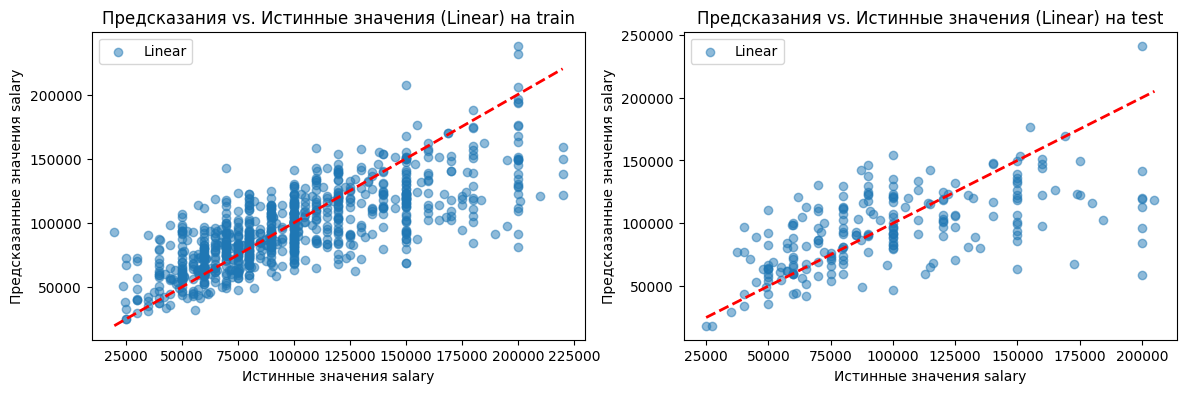

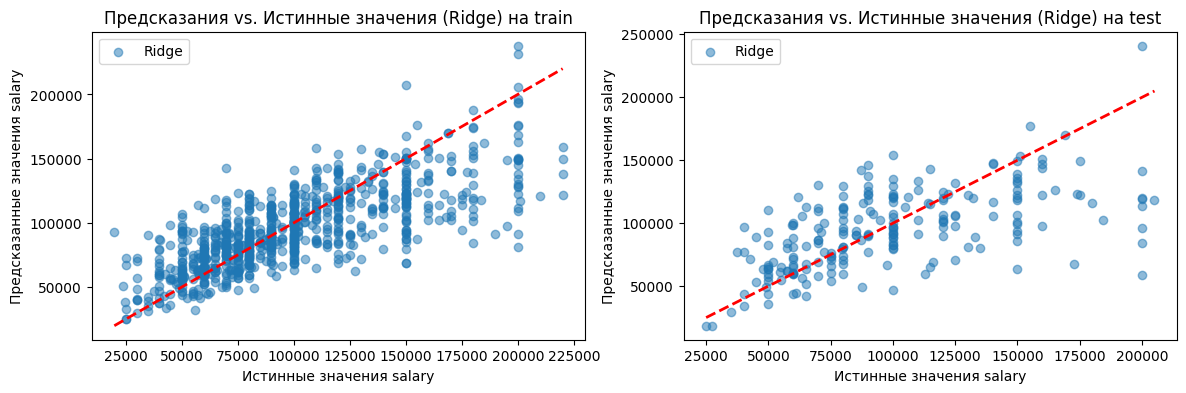

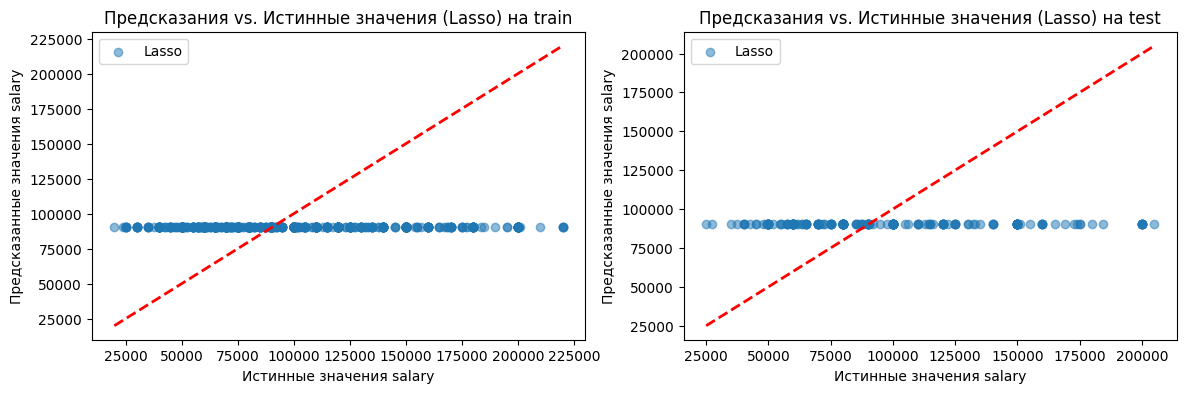

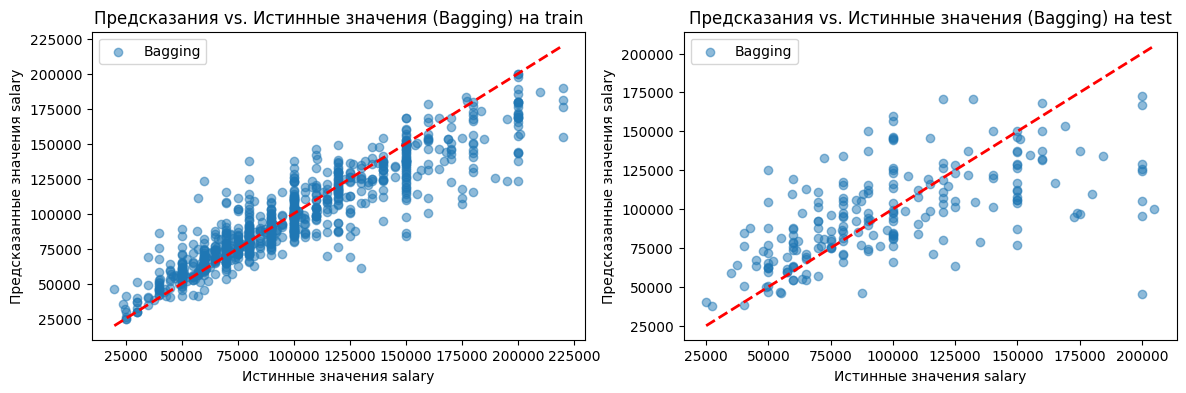

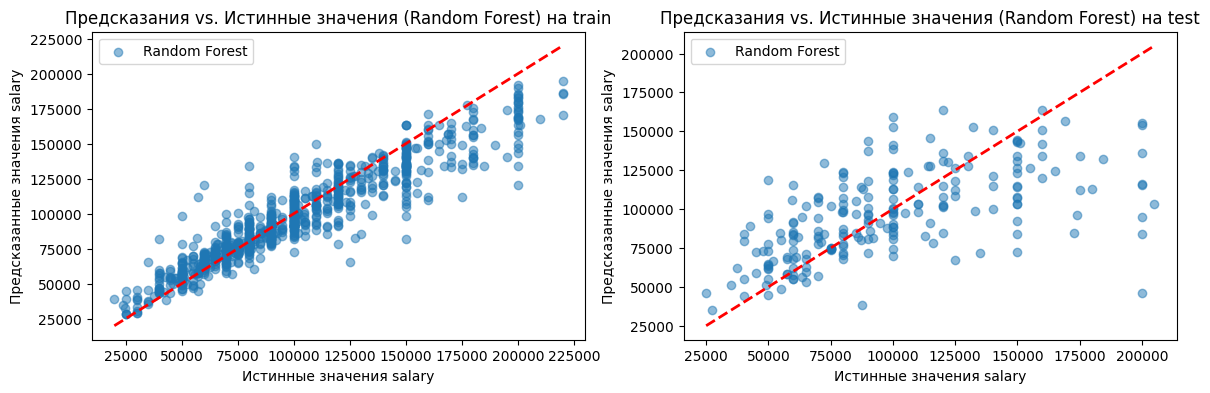

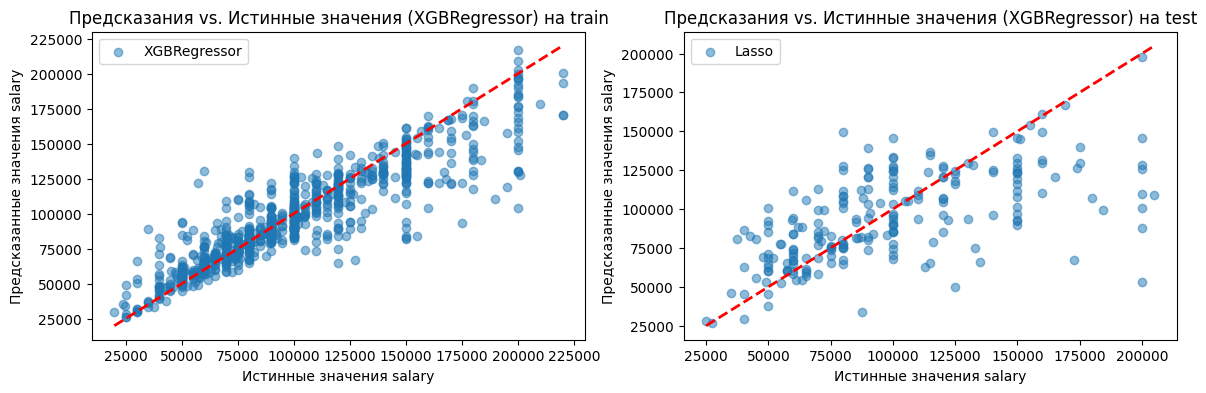

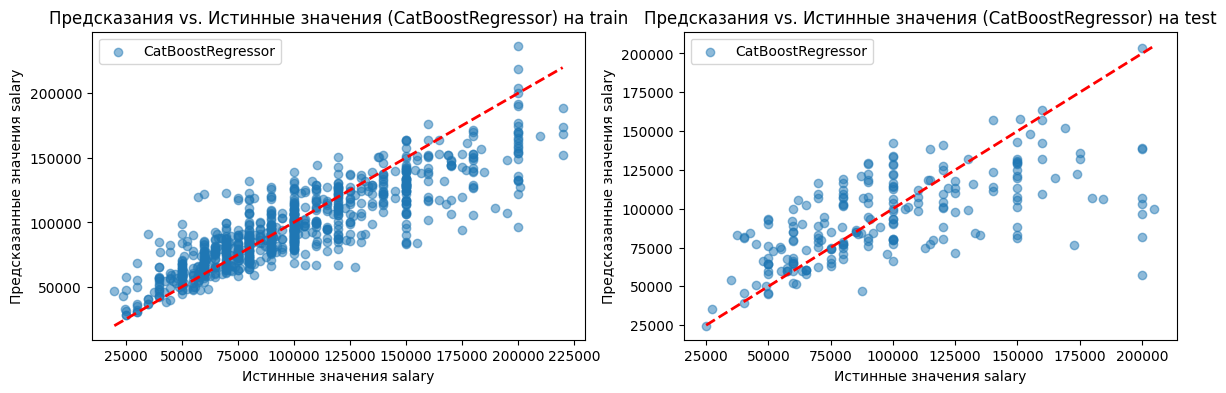

In [ ]:
# График предсказаний vs. истинных значений для Linear
plt.figure(figsize=(14,4))

plt.subplot(1, 2, 1)
plt.scatter(np.expm1(y_train), np.expm1(y_train_pred_linreg), alpha=0.5, label='Linear')
plt.plot([np.expm1(y_train).min(), np.expm1(y_train).max()], [np.expm1(y_train).min(), np.expm1(y_train).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (Linear) на train')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(np.expm1(y_test), np.expm1(y_test_pred_linreg), alpha=0.5, label='Linear')
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], [np.expm1(y_test).min(), np.expm1(y_test).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (Linear) на test')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.show()

# График предсказаний vs. истинных значений для Ridge
plt.figure(figsize=(14,4))

plt.subplot(1, 2, 1)
plt.scatter(np.expm1(y_train), np.expm1(y_train_pred_ridge), alpha=0.5, label='Ridge')
plt.plot([np.expm1(y_train).min(), np.expm1(y_train).max()], [np.expm1(y_train).min(), np.expm1(y_train).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (Ridge) на train')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(np.expm1(y_test), np.expm1(y_test_pred_ridge), alpha=0.5, label='Ridge')
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], [np.expm1(y_test).min(), np.expm1(y_test).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (Ridge) на test')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.show()

# График предсказаний vs. истинных значений для Lasso
plt.figure(figsize=(14,4))

plt.subplot(1, 2, 1)
plt.scatter(np.expm1(y_train), np.expm1(y_train_pred_lasso), alpha=0.5, label='Lasso')
plt.plot([np.expm1(y_train).min(), np.expm1(y_train).max()], [np.expm1(y_train).min(), np.expm1(y_train).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (Lasso) на train')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(np.expm1(y_test), np.expm1(y_test_pred_lasso), alpha=0.5, label='Lasso')
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], [np.expm1(y_test).min(), np.expm1(y_test).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (Lasso) на test')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.show()

# График предсказаний vs. истинных значений для Bagging Regressor
plt.figure(figsize=(14,4))

plt.subplot(1, 2, 1)
plt.scatter(np.expm1(y_train), np.expm1(y_train_pred_bag), alpha=0.5, label='Bagging')
plt.plot([np.expm1(y_train).min(), np.expm1(y_train).max()], [np.expm1(y_train).min(), np.expm1(y_train).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (Bagging) на train')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(np.expm1(y_test), np.expm1(y_test_pred_bag), alpha=0.5, label='Bagging')
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], [np.expm1(y_test).min(), np.expm1(y_test).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (Bagging) на test')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.show()

# График предсказаний vs. истинных значений для Random Forest
plt.figure(figsize=(14,4))

plt.subplot(1, 2, 1)
plt.scatter(np.expm1(y_train), np.expm1(y_train_pred_rf), alpha=0.5, label='Random Forest')
plt.plot([np.expm1(y_train).min(), np.expm1(y_train).max()], [np.expm1(y_train).min(), np.expm1(y_train).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (Random Forest) на train')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(np.expm1(y_test), np.expm1(y_test_pred_rf), alpha=0.5, label='Random Forest')
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], [np.expm1(y_test).min(), np.expm1(y_test).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (Random Forest) на test')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.show()

# График предсказаний vs. истинных значений для XGBRegressor
plt.figure(figsize=(14,4))

plt.subplot(1, 2, 1)
plt.scatter(np.expm1(y_train), np.expm1(y_train_pred_xgb), alpha=0.5, label='XGBRegressor')
plt.plot([np.expm1(y_train).min(), np.expm1(y_train).max()], [np.expm1(y_train).min(), np.expm1(y_train).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (XGBRegressor) на train')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(np.expm1(y_test), np.expm1(y_test_pred_xgb), alpha=0.5, label='Lasso')
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], [np.expm1(y_test).min(), np.expm1(y_test).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (XGBRegressor) на test')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.show()

# График предсказаний vs. истинных значений для CatBoostRegressor
plt.figure(figsize=(14,4))

plt.subplot(1, 2, 1)
plt.scatter(np.expm1(y_train), np.expm1(y_train_pred_cat), alpha=0.5, label='CatBoostRegressor')
plt.plot([np.expm1(y_train).min(), np.expm1(y_train).max()], [np.expm1(y_train).min(), np.expm1(y_train).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (CatBoostRegressor) на train')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(np.expm1(y_test), np.expm1(y_test_pred_cat), alpha=0.5, label='CatBoostRegressor')
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], [np.expm1(y_test).min(), np.expm1(y_test).max()], 'r--', lw=2)
plt.title('Предсказания vs. Истинные значения (CatBoostRegressor) на test')
plt.xlabel('Истинные значения salary')
plt.ylabel('Предсказанные значения salary')
plt.legend()

plt.show()

In [ ]:
# Подбор гиперпараметров через GridSearchCV
param_grids = {
    'Bagging Regressor': {'n_estimators': [100, 200, 300]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]},
    'XGBRegressor': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]},
    'CatBoostRegressor': {'learning_rate': [0.01, 0.1], 'l2_leaf_reg': [1, 3, 5], 'bagging_temperature': [0.5, 1]}
}

base_models = {
    'Bagging Regressor': BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'CatBoostRegressor': CatBoostRegressor(random_state=42, verbose=0)
}

best_estimators = {}
best_params = {}
best_scores = {}

for name in base_models.keys():
    print(f'=== GridSearchCV для {name} ===')
    grid = GridSearchCV(base_models[name], param_grids[name],
                        scoring='r2', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)

    best_estimators[name] = grid.best_estimator_
    best_params[name] = grid.best_params_
    best_scores[name] = grid.best_score_

    print(f'Лучшие параметры: {grid.best_params_}')
    print(f'Лучшая точность на кросс-валидации: {grid.best_score_:.4f}\n')

=== GridSearchCV для Bagging Regressor ===
Лучшие параметры: {'n_estimators': 100}
Лучшая точность на кросс-валидации: 0.3721

=== GridSearchCV для Random Forest ===
Лучшие параметры: {'max_depth': 7, 'n_estimators': 100}
Лучшая точность на кросс-валидации: 0.4197

=== GridSearchCV для XGBRegressor ===
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Лучшая точность на кросс-валидации: 0.4449

=== GridSearchCV для CatBoostRegressor ===
Лучшие параметры: {'bagging_temperature': 0.5, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Лучшая точность на кросс-валидации: 0.4578



# Оценка качества модели на тестовой выборке

Качество модели оценивалось с использованием следующих метрик:

- RMSE (Root Mean Squared Error): Корень среднеквадратичной ошибки,
чувствительная к крупным отклонениям.

- MAE (Mean Absolute Error): Средняя абсолютная ошибка, показывающая среднюю погрешность предсказания.

- R² (R-squared): Коэффициент детерминации, отражающий долю объясненной вариации целевой переменной.

- Кросс-валидация (5-fold): Использовалась для получения более надежной оценки R².

## Результаты по обученным моделям

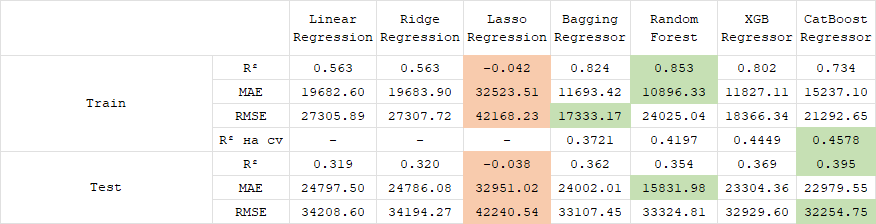

Лучшие модели по метрикам:
- Random Forest
- CatBoostRegressor

Худшая модель по метрикам:
- Lasso Regression



---


#Проведенные эксперименты
---
##Отбор признаков

- На этапе предобработки данных исключены неинформативные признаки и составляющие таргета из фичей
- Отбор топ 50 навыков и ограничение топ 100 работодателей
- Новый признак: количество навыков

##Изменение обучаемой модели

- Применение L1 и L2 регуляризации: без значимого улучшения
- Применение ансамблевых моделей: значимое улучшение R² на трейне (>0.8), умеренное снижение RMSE и MAE

##Изменение гиперпараметров

- Подбор гиперпараметров для 4 моделей
- Лучший результат по R² на кросс-валидации по 5 фолдам: CatBoostRegressor (0.4578)